

    Preprocess the data: Ensure that data is properly formatted and cleaned, use pandas for handling and preprocessing the data.

    Train the model: Split the data into training and testing sets, and train chosen model on the training data.

    Serialize the model: Save the trained model as a pickle file using Python's pickle library.

    Add an API endpoint to Flask application: Create a new API endpoint that will receive features through a GET request and return the predicted output after deserializing the model.



In [3]:
import pickle
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib
import numpy as np

### Processing the Data ###

In [4]:
# Load data from CSV file or database
df_bikes = pd.read_csv('availability.csv', delimiter=';', encoding='ISO-8859-1')
df_weather  = pd.read_csv('weather.csv', delimiter=';', encoding='ISO-8859-1')
df_cb = pd.read_csv('currentbikes.csv', delimiter=';', encoding='ISO-8859-1')

In [5]:
df_cb

,number,name,status,available_bike_stands,available_bikes,lastUpdate
0,42,SMITHFIELD NORTH,OPEN,3,26,1680597632000
1,30,PARNELL SQUARE NORTH,OPEN,1,19,1680597655000
2,54,CLONMEL STREET,OPEN,21,12,1680597665000
3,108,AVONDALE ROAD,OPEN,1,34,1680597712000
4,20,JAMES STREET EAST,OPEN,25,4,1680597975000
...,...,...,...,...,...,...
109,39,WILTON TERRACE,OPEN,8,12,1680597921000
110,83,EMMET ROAD,OPEN,0,40,1680597687000
111,92,HEUSTON BRIDGE (NORTH),OPEN,0,40,1680597733000
112,21,LEINSTER STREET SOUTH,OPEN,17,13,1680598055000


In [6]:
#change df_bikes lastUpdate column to datetime format 

df_bikes['lastUpdate'] = pd.to_datetime(df_bikes['lastUpdate'], unit='ms')
df_bikes['name'] = df_bikes['name'].str.replace('/', '')
df_cb['name'] = df_bikes['name'].str.replace('/', '')

### Show/Delete Duplicate Rows for Bikes ###


We need to find duplicate rows on a certain column, for example if all columns match

In [7]:
# Keep first occurrence of each duplicate row and delete subsequent occurrences
df_bikes = df_bikes.drop_duplicates(keep='first')

In [8]:
df_bikes

,name,status,available_bike_stands,available_bikes,lastUpdate
0,SMITHFIELD NORTH,OPEN,16,14,2023-03-06 14:26:25
1,PARNELL SQUARE NORTH,OPEN,1,19,2023-03-06 14:25:26
2,CLONMEL STREET,OPEN,17,16,2023-03-06 14:21:39
3,AVONDALE ROAD,OPEN,15,20,2023-03-06 14:23:34
4,JAMES STREET EAST,OPEN,22,8,2023-03-06 14:30:20
...,...,...,...,...,...
625066,ORMOND QUAY UPPER,OPEN,27,2,2023-03-25 17:08:04
625068,MOUNTJOY SQUARE WEST,OPEN,10,20,2023-03-25 17:07:12
625069,WILTON TERRACE,OPEN,5,15,2023-03-25 17:09:09
625071,HEUSTON BRIDGE (NORTH),OPEN,39,1,2023-03-25 17:09:23


###  Show/Delete Duplicate Rows for Weather  ###

In [9]:
df_weather[df_weather.duplicated(subset=['last_updated'], keep=False)].sort_values(by=['last_updated'])


,last_updated,temp,windspeed,pressure,precipitation,humidity,feelslike,wind_dir,weather_condition,local_time
2,2023-03-06 17:15:00,5,9,1003.0,0.5,87.0,3.2,WNW,Light rain,2023-03-06 17:15
3,2023-03-06 17:15:00,5,7,1003.0,0.5,93.0,3.2,NNW,Light rain,2023-03-06 17:20
4,2023-03-06 17:15:00,5,7,1003.0,0.5,93.0,3.2,NNW,Light rain,2023-03-06 17:25
5,2023-03-06 17:15:00,5,7,1003.0,0.5,93.0,3.2,NNW,Light rain,2023-03-06 17:30
6,2023-03-06 17:30:00,5,7,1003.0,0.5,93.0,3.2,NNW,Light rain,2023-03-06 17:35
...,...,...,...,...,...,...,...,...,...,...
5469,2023-03-25 16:45:00,11,9,1001.0,0.0,71.0,9.5,SSW,Partly cloudy,2023-03-25 16:55
5467,2023-03-25 16:45:00,11,9,1002.0,0.0,71.0,9.5,S,Partly cloudy,2023-03-25 16:45
5470,2023-03-25 16:45:00,10,11,1001.0,0.0,82.0,8.3,SW,Partly cloudy,2023-03-25 17:00
5471,2023-03-25 17:00:00,11,9,1001.0,0.1,71.0,10.1,SSW,Partly cloudy,2023-03-25 17:05


In [10]:
# Keep first occurrence of each duplicate 'lastUpdate' row and delete subsequent occurrences
df_weather = df_weather.drop_duplicates(subset=['last_updated'], keep='first')

### round lastUpdate in dfbikes to 15  minute intervals ### 

In [11]:
### round lastUpdate in dfbikes to 15  minute intervals ### 
df_bikes['lastUpdate'] = df_bikes['lastUpdate'].dt.round('15min')

### make a column the same between  df_bikes and df_weather ###

In [12]:
#change lastUpdate in dfBikes to match with lastUpdate in df_weather  

#rename last_updated to lastUpdate
df_weather = df_weather.rename(columns={'last_updated': 'lastUpdate'})

df_weather.head()

,lastUpdate,temp,windspeed,pressure,precipitation,humidity,feelslike,wind_dir,weather_condition,local_time
0,2023-03-06 14:15:00,5,11,1004.0,0.3,93.0,1.8,WNW,Light rain,2023-03-06 14:30
1,2023-03-06 14:30:00,5,11,1005.0,0.3,87.0,1.8,WNW,Light rain,2023-03-06 14:35
2,2023-03-06 17:15:00,5,9,1003.0,0.5,87.0,3.2,WNW,Light rain,2023-03-06 17:15
6,2023-03-06 17:30:00,5,7,1003.0,0.5,93.0,3.2,NNW,Light rain,2023-03-06 17:35
8,2023-03-06 17:45:00,5,7,1003.0,0.5,93.0,3.2,NNW,Light rain,2023-03-06 17:45


### we need to make a df for each station ###

In [13]:
unique_names = df_bikes['name'].unique().tolist()
print(unique_names)

['SMITHFIELD NORTH', 'PARNELL SQUARE NORTH', 'CLONMEL STREET', 'AVONDALE ROAD', 'JAMES STREET EAST', 'MOUNT STREET LOWER', 'CHRISTCHURCH PLACE', 'GRANTHAM STREET', 'PEARSE STREET', 'YORK STREET EAST', 'EXCISE WALK', 'FITZWILLIAM SQUARE WEST', 'PORTOBELLO ROAD', 'PARNELL STREET', 'FREDERICK STREET SOUTH', 'FOWNES STREET UPPER', 'CLARENDON ROW', 'CUSTOM HOUSE', 'RATHDOWN ROAD', "NORTH CIRCULAR ROAD (O'CONNELL'S)", 'HANOVER QUAY', 'OLIVER BOND STREET', 'COLLINS BARRACKS MUSEUM', 'BROOKFIELD ROAD', 'BENSON STREET', 'EARLSFORT TERRACE', 'GOLDEN LANE', 'DEVERELL PLACE', 'WILTON TERRACE (PARK)', 'JOHN STREET WEST', 'FENIAN STREET', 'MERRION SQUARE SOUTH', 'SOUTH DOCK ROAD', 'CITY QUAY', 'EXCHEQUER STREET', 'THE POINT', 'BROADSTONE', 'HATCH STREET', 'LIME STREET', 'CHARLEMONT PLACE', 'KILMAINHAM GAOL', 'HARDWICKE PLACE', 'WOLFE TONE STREET', 'FRANCIS STREET', 'GREEK STREET', 'GUILD STREET', 'HERBERT PLACE', 'HIGH STREET', 'NORTH CIRCULAR ROAD', 'WESTERN WAY', 'TALBOT STREET', 'NEWMAN HOUSE', "

In [14]:
df_SMITHFIELD_NORTH = df_bikes[df_bikes['name'] == 'CLONMEL STREET'].copy()
# df_SMITHFIELD_NORTH[df_SMITHFIELD_NORTH.duplicated(keep=True)]


In [15]:
df_SMITHFIELD_NORTH

,name,status,available_bike_stands,available_bikes,lastUpdate
2,CLONMEL STREET,OPEN,17,16,2023-03-06 14:15:00
117,CLONMEL STREET,OPEN,17,16,2023-03-06 14:30:00
232,CLONMEL STREET,OPEN,11,22,2023-03-06 17:15:00
347,CLONMEL STREET,OPEN,10,23,2023-03-06 17:15:00
577,CLONMEL STREET,OPEN,10,23,2023-03-06 17:30:00
...,...,...,...,...,...
624050,CLONMEL STREET,OPEN,1,32,2023-03-25 16:30:00
624278,CLONMEL STREET,OPEN,1,32,2023-03-25 16:45:00
624506,CLONMEL STREET,OPEN,1,32,2023-03-25 16:45:00
624734,CLONMEL STREET,OPEN,1,32,2023-03-25 17:00:00


### Train the Model ###

- We want to predict 'available_bikes' from my df_bikes based on the following columns:
    - 'lastUpdate' from df_bikes 
    -  'precipitation', 'windspeed' and 'temp' from df_weather

In [16]:
df_bikes.dtypes

name                             object
status                           object
available_bike_stands             int64
available_bikes                   int64
lastUpdate               datetime64[ns]
dtype: object

In [17]:
df_weather.dtypes

lastUpdate            object
temp                   int64
windspeed              int64
pressure             float64
precipitation        float64
humidity             float64
feelslike            float64
wind_dir              object
weather_condition     object
local_time            object
dtype: object

In [18]:
df_weather['lastUpdate'] = pd.to_datetime(df_weather['lastUpdate'])

In [19]:
# merge relevant columns from df_bikes and df_weather into one df 
df_merge = pd.merge(df_SMITHFIELD_NORTH[['lastUpdate', 'available_bikes']], df_weather[['lastUpdate', 'humidity', 'precipitation', 'windspeed', 'temp']], on='lastUpdate', how='inner')

In [20]:
##Separate the merged dataframe into input features (X) and output variable (y):
x = df_merge[['lastUpdate', 'humidity', 'precipitation', 'windspeed', 'temp']]
y = df_merge['available_bikes']

In [21]:
df_merge.dtypes

lastUpdate         datetime64[ns]
available_bikes             int64
humidity                  float64
precipitation             float64
windspeed                   int64
temp                        int64
dtype: object

In [22]:
# # Convert datetime column to timestamp in seconds
df_merge['lastUpdate'] = df_merge['lastUpdate'].astype(int) // 10**9

df_merge['lastUpdate'] = pd.to_datetime(df_merge['lastUpdate'], unit='s')
df_merge['hour_of_day'] = df_merge['lastUpdate'].dt.hour
df_merge['Day_of_Week'] = df_merge['lastUpdate'].dt.dayofweek
# Normalize the numeric columns
scaler = StandardScaler()
numeric_cols = ['precipitation', 'windspeed', 'temp']
df_merge[numeric_cols] = scaler.fit_transform(df_merge[numeric_cols])

x = df_merge[['hour_of_day', 'Day_of_Week', 'precipitation', 'windspeed', 'temp']]
y = df_merge['available_bikes']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Fit the model using the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the performance using the testing data
score = model.score(X_test, y_test)
print(f"R^2 score on testing data: {score}")




R^2 score on testing data: 0.015643939673018803


In [23]:
print(df_merge['Day_of_Week'].unique())

[0 1 2 3 4 5 6]


In [24]:
df_merge.dtypes

lastUpdate         datetime64[ns]
available_bikes             int64
humidity                  float64
precipitation             float64
windspeed                 float64
temp                      float64
hour_of_day                 int64
Day_of_Week                 int64
dtype: object

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

model = LinearRegression() # choose your own model here...
model.fit(X_train, y_train)

LinearRegression()

In [26]:
#Predict the 'available_bikes' using the testing data:
y_pred = model.predict(X_test)

In [27]:
from sklearn.metrics import mean_squared_error
import math
#Evaluate the performance of your model:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

#on average, the predicted values are off by the square root of 31 (~5)

x = math.sqrt(mse)
print(x)

Mean Squared Error: 31.471551066072127
5.609951075194162


### RandomForestRegressor ###

In [46]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor() # create instance of the model
model.fit(X_train, y_train) # fit the model to the training data

y_pred = model.predict(X_test)

#Evaluate the performance of your model:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


x = math.sqrt(mse)
print(x)

score = model.score(X_test, y_test)
print(f"R^2 score on testing data: {score}")


Mean Squared Error: 2.4348367670351854
1.5603963493405082
R^2 score on testing data: 0.9701124753811747


In [29]:
df_bikes['name'].unique().sum()

"SMITHFIELD NORTHPARNELL SQUARE NORTHCLONMEL STREETAVONDALE ROADJAMES STREET EASTMOUNT STREET LOWERCHRISTCHURCH PLACEGRANTHAM STREETPEARSE STREETYORK STREET EASTEXCISE WALKFITZWILLIAM SQUARE WESTPORTOBELLO ROADPARNELL STREETFREDERICK STREET SOUTHFOWNES STREET UPPERCLARENDON ROWCUSTOM HOUSERATHDOWN ROADNORTH CIRCULAR ROAD (O'CONNELL'S)HANOVER QUAYOLIVER BOND STREETCOLLINS BARRACKS MUSEUMBROOKFIELD ROADBENSON STREETEARLSFORT TERRACEGOLDEN LANEDEVERELL PLACEWILTON TERRACE (PARK)JOHN STREET WESTFENIAN STREETMERRION SQUARE SOUTHSOUTH DOCK ROADCITY QUAYEXCHEQUER STREETTHE POINTBROADSTONEHATCH STREETLIME STREETCHARLEMONT PLACEKILMAINHAM GAOLHARDWICKE PLACEWOLFE TONE STREETFRANCIS STREETGREEK STREETGUILD STREETHERBERT PLACEHIGH STREETNORTH CIRCULAR ROADWESTERN WAYTALBOT STREETNEWMAN HOUSESIR PATRICK DUN'SNEW CENTRAL BANKGRANGEGORMAN LOWER (CENTRAL)KING STREET NORTHKILLARNEY STREETHERBERT STREETHANOVER QUAY EASTCUSTOM HOUSE QUAYMOLESWORTH STREETGEORGES QUAYKILMAINHAM LANEMOUNT BROWNMARKET STREE

In [30]:
df_cb['name'].unique()

array(['SMITHFIELD NORTH', 'PARNELL SQUARE NORTH', 'CLONMEL STREET',
       'AVONDALE ROAD', 'JAMES STREET EAST', 'MOUNT STREET LOWER',
       'CHRISTCHURCH PLACE', 'GRANTHAM STREET', 'PEARSE STREET',
       'YORK STREET EAST', 'EXCISE WALK', 'FITZWILLIAM SQUARE WEST',
       'PORTOBELLO ROAD', 'PARNELL STREET', 'FREDERICK STREET SOUTH',
       'FOWNES STREET UPPER', 'CLARENDON ROW', 'CUSTOM HOUSE',
       'RATHDOWN ROAD', "NORTH CIRCULAR ROAD (O'CONNELL'S)",
       'HANOVER QUAY', 'OLIVER BOND STREET', 'COLLINS BARRACKS MUSEUM',
       'BROOKFIELD ROAD', 'BENSON STREET', 'EARLSFORT TERRACE',
       'GOLDEN LANE', 'DEVERELL PLACE', 'WILTON TERRACE (PARK)',
       'JOHN STREET WEST', 'FENIAN STREET', 'MERRION SQUARE SOUTH',
       'SOUTH DOCK ROAD', 'CITY QUAY', 'EXCHEQUER STREET', 'THE POINT',
       'BROADSTONE', 'HATCH STREET', 'LIME STREET', 'CHARLEMONT PLACE',
       'KILMAINHAM GAOL', 'HARDWICKE PLACE', 'WOLFE TONE STREET',
       'FRANCIS STREET', 'GREEK STREET', 'GUILD STREET', 

In [31]:
# Get the unique names in df1 and df2
df1_names = set(df_bikes['name'])
df2_names = set(df_cb['name'])

# Find the names that are only in df1
df1_only_names = df1_names - df2_names

# Find the names that are only in df2
df2_only_names = df2_names - df1_names

# Print the results
print("Names only in df1:", df1_only_names)
print("Names only in df2:", df2_only_names)


Names only in df1: {'BLACKHALL PLACE'}
Names only in df2: set()


We are off by 3 bikes

### Split lastUpdate into days of the week and add features  ###

we need to loop through every station and apply the model

the issue is that the code is out of order below so if we follow all the code above we should be grand. 

In [32]:
df_bikes['hour_of_day'] = df_bikes['lastUpdate'].dt.hour
df_bikes['Day_of_Week'] = df_bikes['lastUpdate'].dt.dayofweek

# df_bikes = pd.merge(df_bikes[['name', 'lastUpdate', 'available_bikes', 'hour_of_day', 'Day_of_Week']], df_cb['number'], on='name', how='inner')

df_bikes = pd.merge(df_bikes[['name', 'lastUpdate', 'available_bikes', 'hour_of_day', 'Day_of_Week']], df_weather[['lastUpdate', 'humidity', 'precipitation', 'windspeed', 'temp']], on='lastUpdate', how='inner')

df_bikes

,name,lastUpdate,available_bikes,hour_of_day,Day_of_Week,humidity,precipitation,windspeed,temp
0,SMITHFIELD NORTH,2023-03-06 14:30:00,14,14,0,87.0,0.3,11,5
1,PARNELL SQUARE NORTH,2023-03-06 14:30:00,19,14,0,87.0,0.3,11,5
2,AVONDALE ROAD,2023-03-06 14:30:00,20,14,0,87.0,0.3,11,5
3,JAMES STREET EAST,2023-03-06 14:30:00,8,14,0,87.0,0.3,11,5
4,MOUNT STREET LOWER,2023-03-06 14:30:00,5,14,0,87.0,0.3,11,5
...,...,...,...,...,...,...,...,...,...
357934,MOUNTJOY SQUARE EAST,2023-03-25 17:00:00,40,17,5,71.0,0.1,9,11
357935,PARKGATE STREET,2023-03-25 17:00:00,15,17,5,71.0,0.1,9,11
357936,BUCKINGHAM STREET LOWER,2023-03-25 17:00:00,16,17,5,71.0,0.1,9,11
357937,ROTHE ABBEY,2023-03-25 17:00:00,31,17,5,71.0,0.1,9,11


In [49]:
stations = df_bikes['name'].unique()


random_forest_scores = []

for i in stations:
    
    df_station = df_bikes[df_bikes['name'] == i].copy()
  
    model = RandomForestRegressor()
    X = df_station[['hour_of_day', 'Day_of_Week', 'humidity', 'precipitation', 'windspeed', 'temp']]
    y = df_station['available_bikes']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    
    score = model.score(X_test, y_test)
    random_forest_scores.append(score)
    print(f"R^2 score for {i} on testing data: {score}, MSE: {rmse}")

    # filename = f'{i}_model.pkl'
    # with open(filename, 'wb') as file:
    #     pickle.dump(model, file)


R^2 score for SMITHFIELD NORTH on testing data: 0.9563745846904378, MSE: 1.8712629388174713
R^2 score for PARNELL SQUARE NORTH on testing data: 0.962132955977103, MSE: 1.2081529363046417
R^2 score for AVONDALE ROAD on testing data: 0.9081898915055155, MSE: 1.9056633931363864
R^2 score for JAMES STREET EAST on testing data: 0.9764102099081636, MSE: 1.149392310760785
R^2 score for MOUNT STREET LOWER on testing data: 0.9748884476262775, MSE: 1.687203449053862
R^2 score for CHRISTCHURCH PLACE on testing data: 0.9504193761792448, MSE: 1.4836968480871207
R^2 score for GRANTHAM STREET on testing data: 0.9320069114966981, MSE: 1.8476626505634213
R^2 score for PEARSE STREET on testing data: 0.9286600157329173, MSE: 1.9797276770763002
R^2 score for YORK STREET EAST on testing data: 0.9657469946400883, MSE: 1.2054085804043195
R^2 score for EXCISE WALK on testing data: 0.9722601014021481, MSE: 1.5662157141204176
R^2 score for FITZWILLIAM SQUARE WEST on testing data: 0.9680225716720233, MSE: 1.2152

In [50]:
print(rmse)

1.5636708070801846


In [51]:
###Testing other models

from sklearn import tree 

decision_tree_scores = []

for i in stations:
    
    df_station = df_bikes[df_bikes['name'] == i].copy()
  
    model = tree.DecisionTreeRegressor()
    X = df_station[['hour_of_day', 'Day_of_Week', 'humidity', 'precipitation', 'windspeed', 'temp']]
    y = df_station['available_bikes']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    
    score = model.score(X_test, y_test)
    decision_tree_scores.append(score) 


    print(f"R^2 score for {i} on testing data: {score}")


R^2 score for SMITHFIELD NORTH on testing data: 0.933755862230316
R^2 score for PARNELL SQUARE NORTH on testing data: 0.9411686280189304
R^2 score for AVONDALE ROAD on testing data: 0.8751873916187753
R^2 score for JAMES STREET EAST on testing data: 0.9768406366174043
R^2 score for MOUNT STREET LOWER on testing data: 0.9703190680206505
R^2 score for CHRISTCHURCH PLACE on testing data: 0.9454017154965629
R^2 score for GRANTHAM STREET on testing data: 0.8909080768330725
R^2 score for PEARSE STREET on testing data: 0.9272088823766249
R^2 score for YORK STREET EAST on testing data: 0.9591605308187227
R^2 score for EXCISE WALK on testing data: 0.9677930209208161
R^2 score for FITZWILLIAM SQUARE WEST on testing data: 0.984110449934085
R^2 score for PORTOBELLO ROAD on testing data: 0.9628089694351517
R^2 score for PARNELL STREET on testing data: 0.8758687132214829
R^2 score for FREDERICK STREET SOUTH on testing data: 0.9336174447083815
R^2 score for FOWNES STREET UPPER on testing data: 0.9631

In [52]:
#Evaluate the performance of your decision tree model:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


x = math.sqrt(mse)
print(x)


Mean Squared Error: 2.9610777125721306
1.7207782287593398


In [36]:
###Testing other models
###Linear Regression 

linear_regression_scores = []

for i in stations:
    
    df_station = df_bikes[df_bikes['name'] == i].copy()
  
    model = LinearRegression()
    X = df_station[['hour_of_day', 'Day_of_Week', 'humidity', 'precipitation', 'windspeed', 'temp']]
    y = df_station['available_bikes']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    score = model.score(X_test, y_test)
    linear_regression_scores.append(score)

    print(f"R^2 score for {i} on testing data: {score}")

R^2 score for SMITHFIELD NORTH on testing data: 0.2680101733604362
R^2 score for PARNELL SQUARE NORTH on testing data: 0.24804150229175626
R^2 score for AVONDALE ROAD on testing data: 0.038032089856035456
R^2 score for JAMES STREET EAST on testing data: 0.22822025695422954
R^2 score for MOUNT STREET LOWER on testing data: 0.15764130901590667
R^2 score for CHRISTCHURCH PLACE on testing data: 0.3391731800305664
R^2 score for GRANTHAM STREET on testing data: 0.1470170203340989
R^2 score for PEARSE STREET on testing data: 0.04270095559298315
R^2 score for YORK STREET EAST on testing data: 0.06661068801197034
R^2 score for EXCISE WALK on testing data: 0.2537446987845364
R^2 score for FITZWILLIAM SQUARE WEST on testing data: 0.2133590677509074
R^2 score for PORTOBELLO ROAD on testing data: 0.13104699863206415
R^2 score for PARNELL STREET on testing data: 0.049548028832947844
R^2 score for FREDERICK STREET SOUTH on testing data: 0.14858772369572426
R^2 score for FOWNES STREET UPPER on testing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


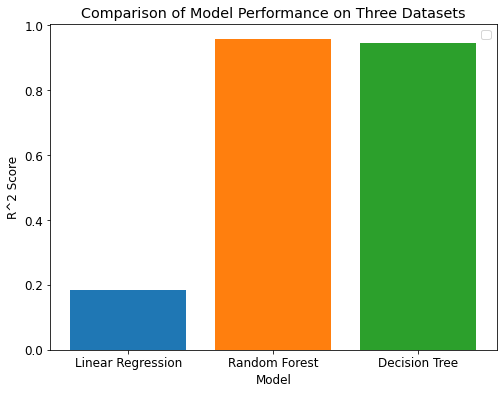

In [37]:
#graphs to visualize the performance of our models

import matplotlib.pyplot as plt
# Define model names and R^2 scores
model_names = ['Linear Regression', 'Random Forest', 'Decision Tree']
# Set figure size and font size
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 12})


x = np.mean(linear_regression_scores)
y = np.mean(random_forest_scores)
z = np.mean(decision_tree_scores)

# Set bar width and positions
bar_width = 0.25
r1 = range(len(linear_regression_scores))
r2 = range(len(random_forest_scores))
r3 = range(len(decision_tree_scores))

# Plot bar chart
plt.bar(model_names[0], x)
plt.bar(model_names[1], y)
plt.bar(model_names[2], z)

# Add x-axis labels and title
plt.xlabel('Model')
plt.ylabel('R^2 Score')
plt.title('Comparison of Model Performance on Three Datasets')

# Add legend
plt.legend()

# Show plot
plt.show()


In [38]:
print(x,y,z)

0.18376911538208027 0.9569952008850211 0.9451630806828278


| Model | R^2 Score |
| --- | --- |
| Linear Regression | 0.18376911538208027 |
| Random Forest | 0.9569952008850211 |
| Decision Tree | 0.9451630806828278 |

| Model | MSE | RMSE |
| --- | --- | --- |
| Linear Regression | 31.471551066072127 | 5.624064041041734 |
| Random Forest | 2.4348367670351854 | 1.559794800050176 |
| Decision Tree | 2.9610777125721306| 1.7214279581265046 |


The RMSE is the square root of the MSE which represents the average difference between the predicted and actual values (the amount of bikes our prediction is off by)

The R^2 score represents the proportion of the variance in the dependent variable (y) that can be explained by the independent variable(s) (x) in a regression model. An R^2 score closer to 1 represents that the model is better at predicting the dependent variable based on the independent variables while a score closer to 0 represents a bad prediction. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


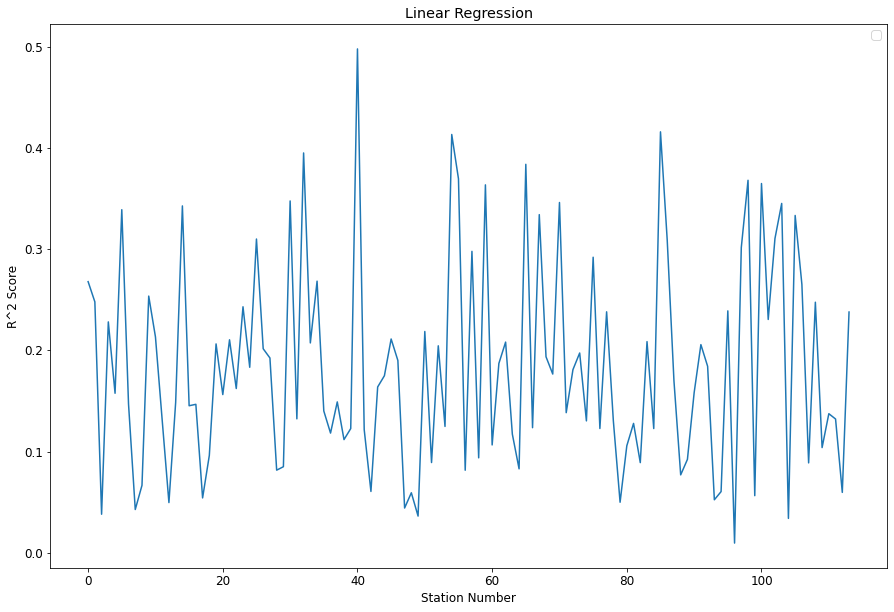

In [39]:
r1 = range(len(linear_regression_scores))
r2 = range(len(random_forest_scores))
r3 = range(len(decision_tree_scores))


plt.figure(figsize=(15,10))



# Plot line chart for linear regression
plt.plot(r1, linear_regression_scores)

# Add x-axis labels and title
plt.xlabel('Station Number')
plt.ylabel('R^2 Score')
plt.title('Linear Regression')

# Add legend
plt.legend()

# Show plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


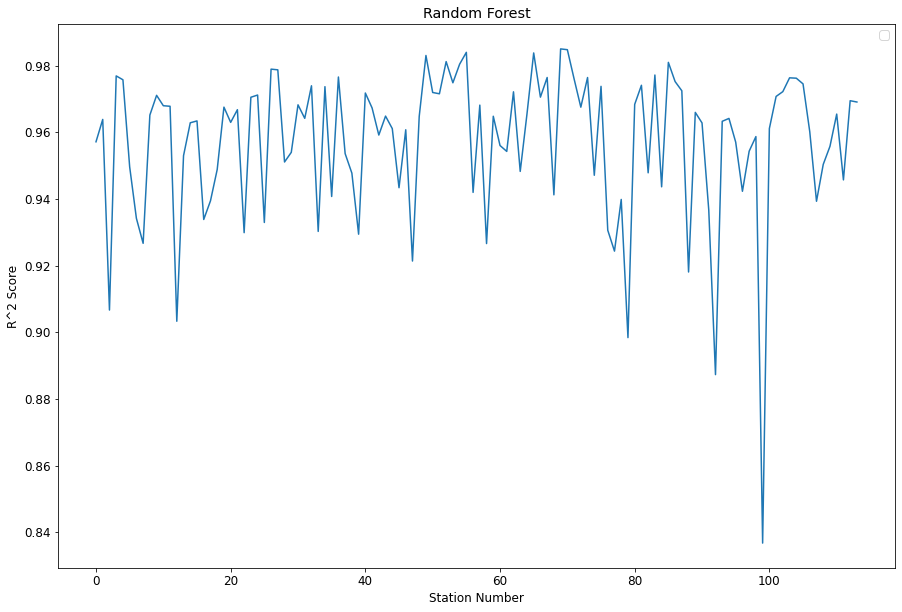

In [40]:
r1 = range(len(linear_regression_scores))
r2 = range(len(random_forest_scores))
r3 = range(len(decision_tree_scores))


plt.figure(figsize=(15,10))



# Plot line chart for linear regression
plt.plot(r2, random_forest_scores)

# Add x-axis labels and title
plt.xlabel('Station Number')
plt.ylabel('R^2 Score')
plt.title('Random Forest')

# Add legend
plt.legend()

# Show plot
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


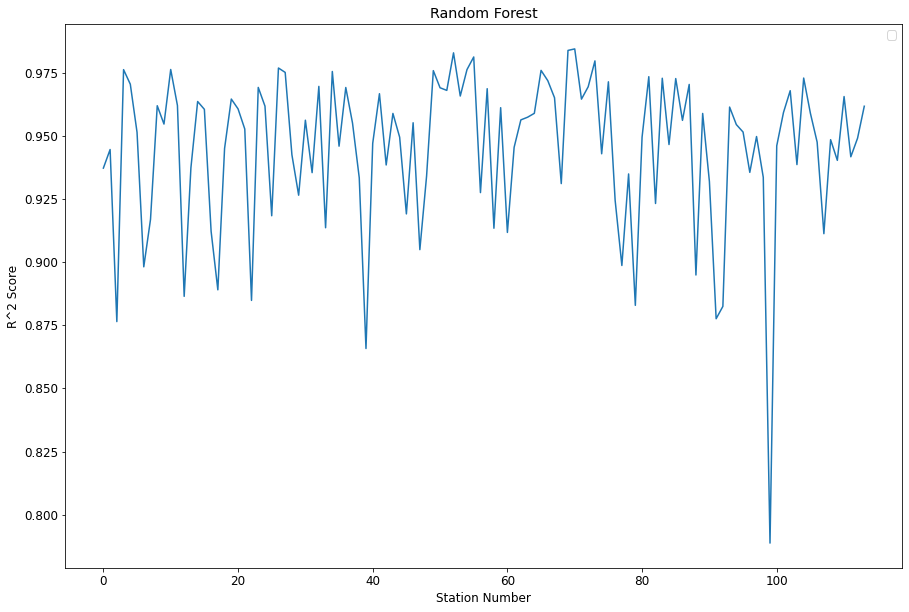

In [41]:

plt.figure(figsize=(15,10))



# Plot line chart for linear regression
plt.plot(r3, decision_tree_scores)

# Add x-axis labels and title
plt.xlabel('Station Number')
plt.ylabel('R^2 Score')
plt.title('Random Forest')

# Add legend
plt.legend()

# Show plot
plt.show()


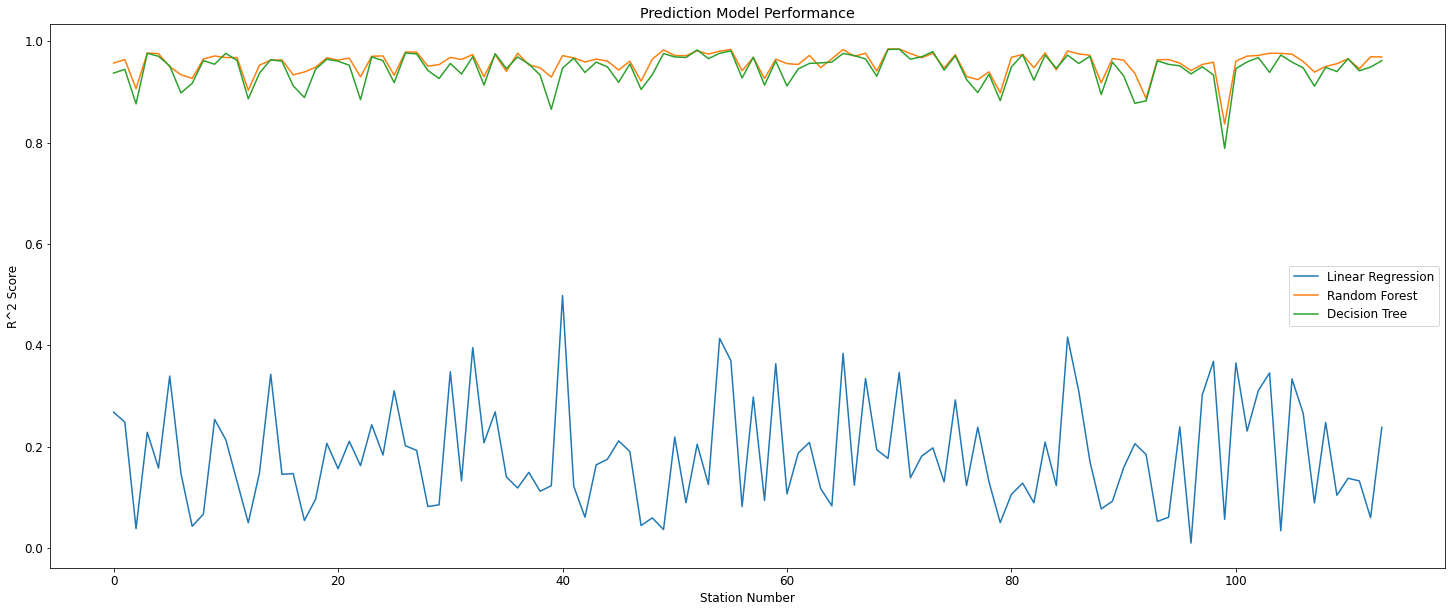

In [43]:
plt.figure(figsize=(25,10))



# Plot line chart for linear regression
#plt.plot(r1, linear_regression_scores, label = 'Linear Regression')
# Plot line chart for linear regression
plt.plot(r1, linear_regression_scores, label = 'Linear Regression')
plt.plot(r2, random_forest_scores, label  = 'Random Forest')
plt.plot(r3, decision_tree_scores, label = 'Decision Tree')

# Add x-axis labels and title
plt.xlabel('Station Number')
plt.ylabel('R^2 Score')
plt.title('Prediction Model Performance')

# Add legend
plt.legend()

# Show plot
plt.show()
